In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)


1.10.0+cu102
0.10.0+cu102


In [3]:
import math
import os
import requests

import matplotlib.pyplot as plt
from IPython.display import Audio, display


_SAMPLE_DIR = "_sample_data"

SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
    uri = [
        (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
        (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
        (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    ]
    for url, path in uri:
        with open(path, 'wb') as file_:
            file_.write(requests.get(url).content)

_fetch_data()

def _get_sample(path, resample=None):
    effects = [
        ["remix", "1"]
    ]
    if resample:
        effects.extend([
            ["lowpass", f"{resample // 2}"],
            ["rate", f'{resample}'],
        ])
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def get_rir_sample(*, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate

def get_noise_sample(*, resample=None):
    return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

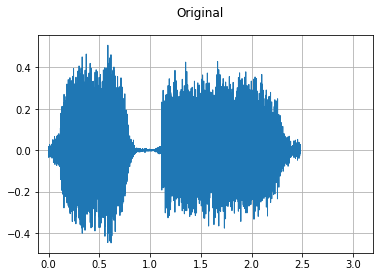

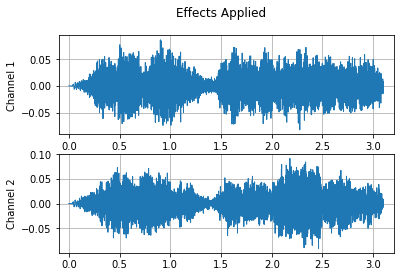

----------
Source: Original
----------
Sample Rate: 16000
Shape: (1, 39680)
Dtype: torch.float32
 - Max:      0.507
 - Min:     -0.448
 - Mean:    -0.000
 - Std Dev:  0.122

tensor([[ 0.0007,  0.0076,  0.0122,  ..., -0.0049, -0.0025,  0.0020]])

----------
Source: Effects Applied
----------
Sample Rate: 16000
Shape: (2, 49600)
Dtype: torch.float32
 - Max:      0.091
 - Min:     -0.091
 - Mean:    -0.000
 - Std Dev:  0.021

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0069, 0.0058, 0.0045],
        [0.0000, 0.0000, 0.0000,  ..., 0.0085, 0.0085, 0.0085]])



In [4]:
waveform1, sample_rate1 = get_sample(resample=16000)

# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate1}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    waveform1, sample_rate1, effects)

plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-.1, 3.2))
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-.1, 3.2))
print_stats(waveform1, sample_rate=sample_rate1, src="Original")
print_stats(waveform2, sample_rate=sample_rate2, src="Effects Applied")


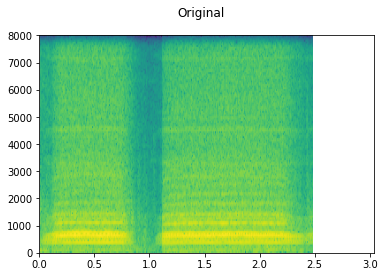

/home/alex/Desktop/Python/audio_augument/venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7580: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


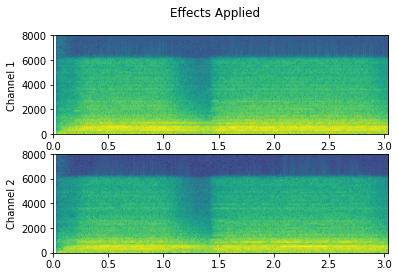

In [5]:
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
play_audio(waveform1, sample_rate1)
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
play_audio(waveform2, sample_rate2)


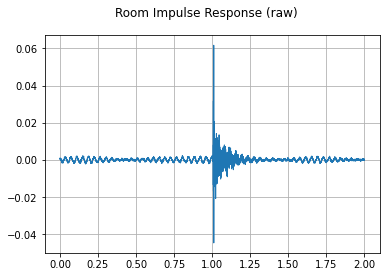

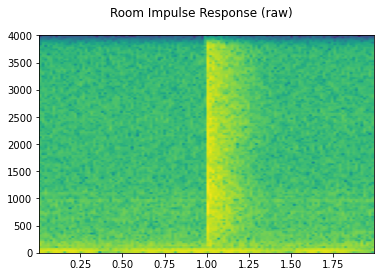

In [6]:
sample_rate = 8000

rir_raw, _ = get_rir_sample(resample=sample_rate)

plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
play_audio(rir_raw, sample_rate)


Shape: (1, 2320)
Dtype: torch.float32
 - Max:      0.395
 - Min:     -0.286
 - Mean:    -0.000
 - Std Dev:  0.021

tensor([[-0.0052, -0.0076, -0.0071,  ...,  0.0184,  0.0173,  0.0070]])



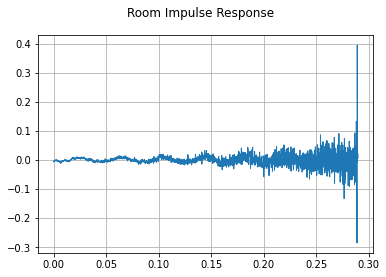

In [7]:
rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
rir = rir / torch.norm(rir, p=2)
rir = torch.flip(rir, [1])

print_stats(rir)
plot_waveform(rir, sample_rate, title="Room Impulse Response", ylim=None)


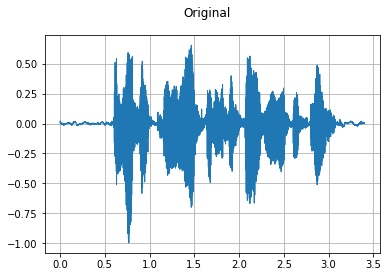

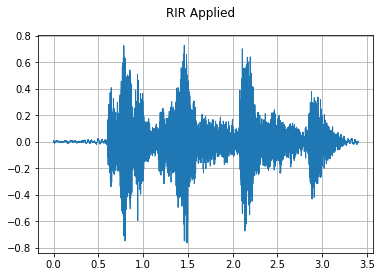

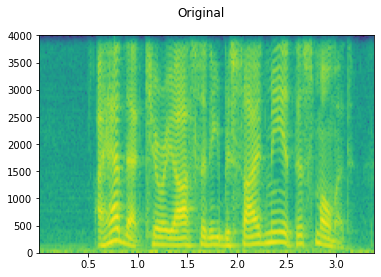

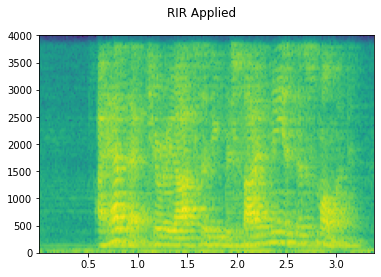

In [8]:
speech, _ = get_speech_sample(resample=sample_rate)

speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_waveform(speech, sample_rate, title="Original", ylim=None)
plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

plot_specgram(augmented, sample_rate, title="RIR Applied")
play_audio(augmented, sample_rate)


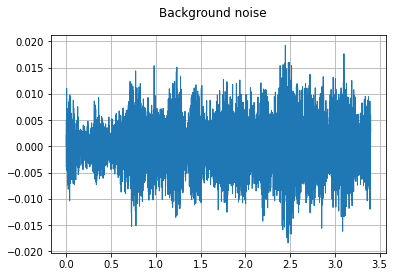

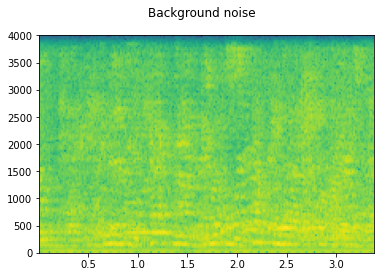

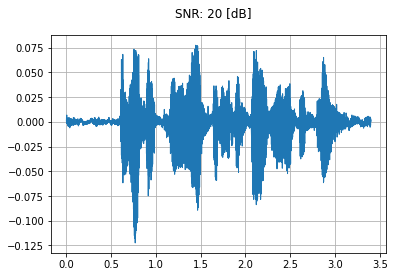

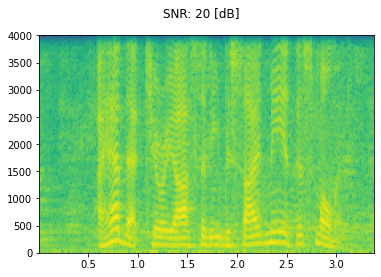

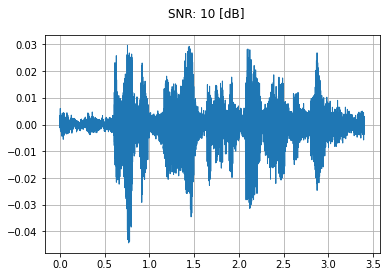

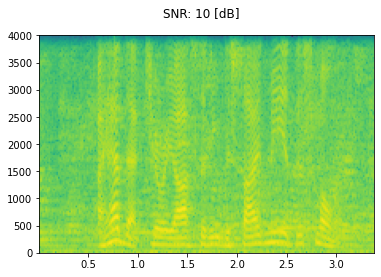

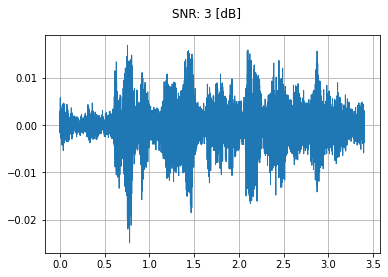

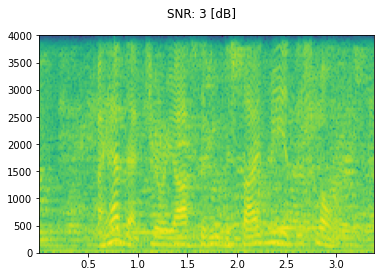

In [66]:
sample_rate = 8000
speech, _ = get_speech_sample(resample=sample_rate)
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
play_audio(noise, sample_rate)

speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)

for snr_db in [20, 10, 3]:
    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    noisy_speech = (scale * speech + noise) / 2

    plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
    plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
    play_audio(noisy_speech, sample_rate)


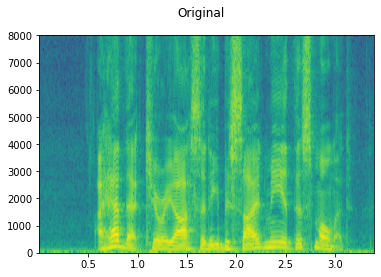

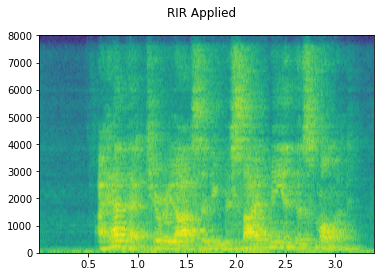

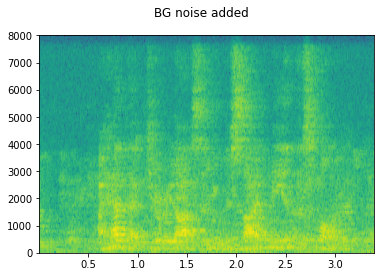

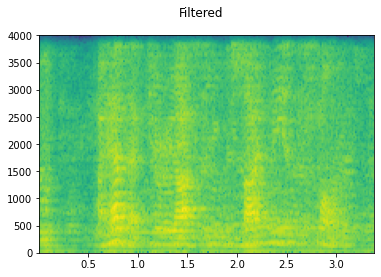

formats: gsm can't encode GSM to 16-bit


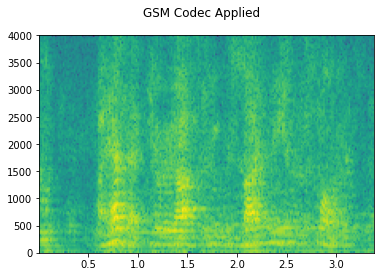

In [12]:
sample_rate = 16000
speech, _ = get_speech_sample(resample=sample_rate)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

# Apply RIR
rir, _ = get_rir_sample(resample=sample_rate, processed=True)
speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
speech = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_specgram(speech, sample_rate, title="RIR Applied")
play_audio(speech, sample_rate)

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

snr_db = 8
scale = math.exp(snr_db / 10) * noise.norm(p=2) / speech.norm(p=2)
speech = (scale * speech + noise) / 2

plot_specgram(speech, sample_rate, title="BG noise added")
play_audio(speech, sample_rate)

# Apply filtering and change sample rate
speech, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
  speech,
  sample_rate,
  effects=[
      ["lowpass", "4000"],
      ["compand", "0.02,0.05", "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8", "-8", "-7", "0.05"],
      ["rate", "8000"],
  ],
)

plot_specgram(speech, sample_rate, title="Filtered")
play_audio(speech, sample_rate)

# Apply telephony codec
speech = F.apply_codec(speech, sample_rate, format="gsm")

plot_specgram(speech, sample_rate, title="GSM Codec Applied")
play_audio(speech, sample_rate)

In [16]:
AUDIO_DIR = "audio"
LONGEST_AUDIO = "3_audio_2021-11-25_22-53-30.wav"
SHORTEST_AUDIO = "4_audio_2021-11-25_22-52-08.wav"

PATH_LONGEST_AUDIO = os.path.join(AUDIO_DIR, LONGEST_AUDIO)
PATH_SHORTEST_AUDIO = os.path.join(AUDIO_DIR, SHORTEST_AUDIO)


In [23]:
sample_rate = 16_000
print("")
l_audio, l_sr = _get_sample(PATH_LONGEST_AUDIO, resample=sample_rate)
s_audio, s_sr = _get_sample(PATH_SHORTEST_AUDIO, resample=sample_rate)
noise, _ = get_noise_sample(resample=sample_rate)

print("Longest audio")
print(f"{l_audio.shape=}; {l_sr=}")
play_audio(l_audio, l_sr)
print()
print("Shortest audio")
print(f"{s_audio.shape=}; {s_sr=}")
play_audio(s_audio, s_sr)


Longest audio
l_audio.shape=torch.Size([1, 100160]); l_sr=16000



Shortest audio
s_audio.shape=torch.Size([1, 19520]); s_sr=16000


In [84]:
import glob
audio_patterns = os.path.join(AUDIO_DIR, "*.wav") 
AUDIO_FILES = glob.glob(audio_patterns)

In [85]:
def apply_bg_noise(audio_path, sample_rate=16_000, show_info=False):
    speech, _ = _get_sample(audio_path, resample=sample_rate)
    noise, _ = get_noise_sample(resample=sample_rate)
    if noise.shape[1] > speech.shape[1]:
        noise = noise[:, :speech.shape[1]]
    else:
        ratio = speech.shape[1] // noise.shape[1] + 1
        noise = noise.repeat((1, ratio))
        noise = noise[:, :speech.shape[1]]

    snr_db = 8
    scale = math.exp(snr_db / 10) * noise.norm(p=2) / speech.norm(p=2)
    speech = (scale * speech + noise) / 2

    if show_info:
        plot_specgram(speech, sample_rate, title="BG noise added")
        play_audio(speech, sample_rate)
    return speech, sample_rate


def apply_rir_noise(audio_path, sample_rate=16_000, show_info=False):
    speech, _ = _get_sample(audio_path, resample=sample_rate)
    rir, _ = get_rir_sample(resample=sample_rate, processed=True)

    speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
    speech = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]
    
    if show_info:
        plot_specgram(speech, sample_rate, title="RIR Applied")
        play_audio(speech, sample_rate)
    return speech, sample_rate
        

def apply_phone_noise(audio_path, sample_rate=8000,  show_info=False):
    speech, _ = _get_sample(audio_path, resample=sample_rate)
    speech = torchaudio.functional.apply_codec(speech, sample_rate, format="gsm")

    if show_info:
        plot_specgram(speech, sample_rate, title="GSM Codec Applied")
        play_audio(speech, sample_rate)
    return speech, sample_rate


sample_rate = 16_000
speech_path = PATH_LONGEST_AUDIO

for speech_path in AUDIO_FILES:
    speech, _ = _get_sample(speech_path, resample=sample_rate)
    #plot_specgram(speech, sample_rate, title="Original")
    #play_audio(speech, sample_rate)

    s_rir, _ = apply_rir_noise(speech_path, sample_rate)
    s_bg, _ = apply_bg_noise(speech_path, sample_rate)
    s_ph, _ = apply_phone_noise(speech_path)

    basename = os.path.basename(speech_path)[:-4]
    path_rir = os.path.join("augumented_audio", basename + "_rir.wav")
    path_bg = os.path.join("augumented_audio", basename + "_bg.wav")
    path_ph = os.path.join("augumented_audio", basename + "_ph.wav")

    torchaudio.save(path_rir, s_rir, sample_rate)
    torchaudio.save(path_bg, s_bg, sample_rate)
    torchaudio.save(path_ph, s_ph, sample_rate)
    print(f"augumented: {speech_path}")

formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_e3bCGtFLHK8G.wav
augumented: audio/4_audio_2021-11-25_22-56-38.wav
augumented: audio/4_J1p8cdPVAt6t.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_kwWS6I907WOv.wav
augumented: audio/2_ooIYfZrlJcke.wav


formats: gsm can't encode GSM to 16-bit


augumented: audio/1_sR3JI8VZftyC.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_iQ3c6SkHeSJ1.wav
augumented: audio/2_audio_2021-11-25_22-56-21.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/4_audio_2021-11-25_22-55-18.wav
augumented: audio/4_Xehdgq5XAKSI.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_audio_2021-11-25_22-51-54.wav
augumented: audio/3_YihXSoLZKDK5.wav


formats: gsm can't encode GSM to 16-bit


augumented: audio/1_audio_2021-11-25_22-50-23.wav


formats: gsm can't encode GSM to 16-bit


augumented: audio/3_lAn8qm0bLKlw.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_audio_2021-11-25_22-55-31.wav
augumented: audio/1_audio_2021-11-25_22-56-13.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/4_h9gRQn1pwKg6.wav
augumented: audio/2_lOSxMwwKmeN2.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_audio_2021-11-25_22-55-54.wav
augumented: audio/2_audio_2021-11-25_22-52-30.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_imizaC1CkO68.wav
augumented: audio/3_FnzpL7wF0xNK.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_kAuGkrSgmRxR.wav
augumented: audio/3_GYtEhKYbqAFZ.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_qncvG5fKGQPx.wav
augumented: audio/2_audio_2021-11-25_22-50-37.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_wbiW1UQXq6I5.wav
augumented: audio/1_audio_2021-11-25_22-52-18.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_audio_2021-11-25_22-54-22.wav
augumented: audio/4_IymDaAg4DzNP.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/4_audio_2021-11-25_22-53-45.wav
augumented: audio/4_XJ7SwZ50hCU5.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_zZPIKGqXwKhQ.wav
augumented: audio/2_audio_2021-11-25_22-54-59.wav


formats: gsm can't encode GSM to 16-bit


augumented: audio/1_HUuxaDiHbosQ.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_audio_2021-11-25_22-53-07.wav
augumented: audio/3_audio_2021-11-25_22-51-20.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_MidI0VnUXrXk.wav
augumented: audio/2_audio_2021-11-25_22-55-44.wav


formats: gsm can't encode GSM to 16-bit


augumented: audio/1_o8RO6QBEVqty.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_audio_2021-11-25_22-53-30.wav
augumented: audio/2_ugK1Jk7cDDkz.wav
augumented: audio/3_1d0xMnR8MmbT.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_audio_2021-11-25_22-51-47.wav
augumented: audio/4_ihBGkL4Mba7V.wav
augumented: audio/3_audio_2021-11-25_22-52-41.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_jrJaGyo4C16i.wav
augumented: audio/4_audio_2021-11-25_22-54-28.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_audio_2021-11-25_22-51-38.wav
augumented: audio/3_audio_2021-11-25_22-56-31.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_NR6M8gAHkQDv.wav
augumented: audio/3_akeftEvL6K3S.wav


formats: gsm can't encode GSM to 16-bit


augumented: audio/4_audio_2021-11-25_22-51-27.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/1_audio_2021-11-25_22-53-57.wav
augumented: audio/1_b7LjU2Xt62fy.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_yDcg8kcdnQKK.wav
augumented: audio/2_aCPmC2pONdXS.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_tI700LFtmu80.wav
augumented: audio/1_audio_2021-11-25_22-54-38.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_Ywm5VofUp6vo.wav
augumented: audio/4_pmdXyIdtXzZl.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/4_Wd6A5gmhtyxy.wav
augumented: audio/2_audio_2021-11-25_22-53-16.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/4_audio_2021-11-25_22-52-50.wav
augumented: audio/4_V0KK3dsMkQkA.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_q1a1qlOvDjmU.wav
augumented: audio/4_jWv3riEyVnvy.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_pgtti6vIANzr.wav
augumented: audio/2_eHXlMXBG9XVd.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/4_audio_2021-11-25_22-56-02.wav
augumented: audio/4_HskzIbFsNrLG.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/2_audio_2021-11-25_22-54-06.wav
augumented: audio/2_GP9L98Z7ARrm.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/4_LTFhnpygru5H.wav
augumented: audio/1_dy3WGZoI0r2J.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


augumented: audio/3_audio_2021-11-25_22-55-09.wav
augumented: audio/1_phZUMTVkm4RF.wav


formats: gsm can't encode GSM to 16-bit


augumented: audio/4_audio_2021-11-25_22-52-08.wav
augumented: audio/1_qzFANEBg1YpY.wav
augumented: audio/3_sIYMxSIsV4Rw.wav


formats: gsm can't encode GSM to 16-bit
formats: gsm can't encode GSM to 16-bit


In [30]:
A = torch.ones(1, 3)
print(A.repeat((1, 3)))
A.shape

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1.]])


torch.Size([1, 3])